# Preprocessing for complex PDF

## Setting
 - Auto Reload
 - path for utils

In [163]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: / already exists
sys.path:  ['/app', '/usr/local/lib/python312.zip', '/usr/local/lib/python3.12', '/usr/local/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/site-packages', '/', '/usr/local/lib/python3.12/site-packages/onnxruntime/transformers', '/usr/local/lib/python3.12/site-packages/onnxruntime/transformers/../tools', '/usr/local/lib/python3.12/site-packages/setuptools/_vendor', '/tmp/tmpnnb5bjvh']


## 1. Create Bedrock client
Amazon Bedrock을 API로 활용하기 위한 Client를 설정합니다. 

In [164]:
import json
import boto3
from pprint import pprint
from src.utils import bedrock, print_ww
from src.utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [165]:
boto3_bedrock = bedrock.get_bedrock_client(
    region="ap-northeast-2",
)

pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: ap-northeast-2
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.ap-northeast-2.amazonaws.com)
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-

## 2. Titan Embedding v2 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [166]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [167]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 2048,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f3f799782f0>], client=<botocore.client.BedrockRuntime object at 0x7f3f78bfbe90>, aws_access_key_id=SecretStr(''), aws_secret_access_key=SecretStr(''), model_id='anthropic.claude-3-5-sonnet-20240620-v1:0', model_kwargs={'stop_sequences': ['\n\nHuman']}, streaming=True, max_tokens=2048)

### Embedding 모델 선택

In [168]:
from langchain_aws import BedrockEmbeddings

In [169]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
)
dimension = 1024 #1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. 데이터 준비 
- https://python.langchain.com/docs/integrations/document_loaders/unstructured_file
- cleansing: https://unstructured-io.github.io/unstructured/core/cleaning.html

### Extract Text, Table and Image from documents

### 3.1 Unstructured.io
Unstructured.io를 이용하여 Document로 부터 Text, Table, 그리고 Image를 추출합니다. 

In [170]:
import shutil
from glob import glob
from src.utils.common_utils import to_pickle, load_pickle
from unstructured.cleaners.core import clean_bullets, clean_extra_whitespace
from langchain_community.document_loaders import UnstructuredFileLoader, UnstructuredAPIFileLoader

#### Parameters
----------
- filename
    - A string defining the target filename path.
- content_type
    - A string defining the file content in MIME type
- file
    - A file-like object using "rb" mode --> open(filename, "rb").
- metadata_filename
    - When file is not None, the filename (string) to store in element metadata. E.g. "foo.txt"
- url
    - The url for a remote document. Pass in content_type if you want partition to treat the document as a specific content_type.
- include_page_breaks
    - If True, the output will include page breaks if the filetype supports it
- strategy
    - The strategy to use for partitioning PDF/image. Uses a layout detection model if set to 'hi_res', otherwise partition simply extracts the text from the document and processes it.
- encoding
    - The encoding method used to decode the text input. If None, utf-8 will be used.
- headers
    - The headers to be used in conjunction with the HTTP request if URL is set.
- skip_infer_table_types
    - The document types that you want to skip table extraction with.
- ssl_verify
    - If the URL parameter is set, determines whether or not partition uses SSL verification in the HTTP request.
- languages
    - The languages present in the document, for use in partitioning and/or OCR. For partitioning <BR>
    image or pdf documents with Tesseract, you'll first need to install the appropriate <BR>
    Tesseract language pack. For other partitions, language is detected using naive Bayesian <BR>
    filter via `langdetect`. Multiple languages indicates text could be in either language. <BR>
    Additional Parameters: <BR>
        - detect_language_per_element <BR>
            - Detect language per element instead of at the document level.
    
- pdf_infer_table_structure
    - If True and strategy=hi_res, any Table Elements extracted from a PDF will include an
    additional metadata field, "text_as_html," where the value (string) is a just a
    transformation of the data into an HTML <table>.
    The "text" field for a partitioned Table Element is always present, whether True or False.
- extract_images_in_pdf
    - Only applicable if `strategy=hi_res`.
    If True, any detected images will be saved in the path specified by
    'extract_image_block_output_dir' or stored as base64 encoded data within metadata fields.
    Deprecation Note: This parameter is marked for deprecation. Future versions will use
    'extract_image_block_types' for broader extraction capabilities.
- extract_image_block_types
    - Only applicable if `strategy=hi_res`.
    Images of the element type(s) specified in this list (e.g., ["Image", "Table"]) will be
    saved in the path specified by 'extract_image_block_output_dir' or stored as base64
    encoded data within metadata fields.
- extract_image_block_to_payload
    - Only applicable if `strategy=hi_res`.
    If True, images of the element type(s) defined in 'extract_image_block_types' will be
    encoded as base64 data and stored in two metadata fields: 'image_base64' and
    'image_mime_type'.
    This parameter facilitates the inclusion of element data directly within the payload,
    especially for web-based applications or APIs.
- extract_image_block_output_dir
    - Only applicable if `strategy=hi_res` and `extract_image_block_to_payload=False`.
    The filesystem path for saving images of the element type(s)
    specified in 'extract_image_block_types'.
- xml_keep_tags
    - If True, will retain the XML tags in the output. Otherwise it will simply extract
    the text from within the tags. Only applies to partition_xml.
- request_timeout
    - The timeout for the HTTP request if URL is set. Defaults to None meaning no timeout and
    requests will block indefinitely.
- hi_res_model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`.
    - https://unstructured-io.github.io/unstructured/best_practices/models.html
- model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`. To be
    deprecated in favor of `hi_res_model_name`.

**추출할 문서의 위치를 입력합니다.**

In [171]:
file_path = "./data/complex_pdf/school_edu_guide.pdf"

**추출된 이미지가 저장될 위치를 입력합니다.**

In [172]:
image_path = "./fig"

In [117]:
if os.path.isdir(image_path): shutil.rmtree(image_path)
os.mkdir(image_path)

loader = UnstructuredFileLoader(
    file_path=file_path,

    chunking_strategy = "by_title",
    mode="elements",

    strategy="hi_res",
    hi_res_model_name="yolox", #"detectron2_onnx", "yolox", "yolox_quantized"

    extract_images_in_pdf=True,
    #skip_infer_table_types='[]', # ['pdf', 'jpg', 'png', 'xls', 'xlsx', 'heic']
    pdf_infer_table_structure=True, ## enable to get table as html using tabletrasformer

    extract_image_block_output_dir=image_path,
    extract_image_block_to_payload=False, ## False: to save image

    max_characters=4096,
    new_after_n_chars=4000,
    combine_text_under_n_chars=2000,

    languages= ["kor+eng"],

    post_processors=[clean_bullets, clean_extra_whitespace]
)

In [173]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

**문서 파싱을 시작합니다 (약 10분 소요)**

In [174]:
%%time
docs = loader.load()

CPU times: user 3min 18s, sys: 3.78 s, total: 3min 22s
Wall time: 6min 4s


In [175]:
tables, texts = [], []
images = glob(os.path.join(image_path, "*"))

In [176]:
tables, texts = [], []

for doc in docs:

    category = doc.metadata["category"]

    if category == "Table": tables.append(doc)
    elif category == "Image": images.append(doc)
    else: texts.append(doc)
    
    images = glob(os.path.join(image_path, "*"))

print (f' # texts: {len(texts)} \n # tables: {len(tables)} \n # images: {len(images)}')

 # texts: 24 
 # tables: 0 
 # images: 60


### 3.2 (Optional) [LlamaParse](https://docs.llamaindex.ai/en/stable/module_guides/loading/connector/llama_parse/) (table parsing)
- LlamaParse를 이용하여, 테이블을 파싱합니다. 해당 작업은 **optional**로써 Unstructured.io의 파싱 결과를 보완할 수 있으며, **defalut setting**은 **False** 입니다. 
- LlamaParse 사용을 위해서는 **API Key가 필요**합니다.

In [177]:
table_by_llama_parse = False

In [122]:
import nest_asyncio
from dotenv import load_dotenv
from llama_parse import LlamaParse
from utils.common_utils import to_markdown
from langchain_community.document_loaders import UnstructuredMarkdownLoader

ModuleNotFoundError: No module named 'llama_parse'

In [ ]:
def api_key():
    os.environ["LLAMA_CLOUD_API_KEY"] = "<your key>"
    nest_asyncio.apply()
    load_dotenv()

In [ ]:
if table_by_llama_parse:
    api_key()
    llamaparse_res = LlamaParse(result_type="markdown").load_data(file_path)
    
    ## Save results as markdown and pickle format
    markdown_path = "./data/complex_pdf/pickle/parsed_llamaparse.md"
    to_pickle(llamaparse_res, "./data/complex_pdf/pickle/parsed_llamaparse.pkl")
    to_markdown(llamaparse_res[0].get_content('text'), markdown_path)
    
    ## Load markdown file into Document loader
    loader = UnstructuredMarkdownLoader(
        file_path=markdown_path,
        mode="elements",
        chunking_strategy="by_title",
        #strategy="hi_res",
        max_characters=4096,
        new_after_n_chars=4000,
        combine_text_under_n_chars=2000,
    )
    docs_llamaparse = loader.load()
    docs_table_llamaparse = [doc for doc in docs_llamaparse if doc.metadata["category"] == "Table"]

#### Show as markdown

In [ ]:
from IPython.display import Markdown, display

In [ ]:
if table_by_llama_parse:
    display(Markdown(markdown_path))

### 3.3 (Optional) [pyMuPDF](https://pymupdf.readthedocs.io/en/latest/) (table parsing)
- PyMuPDF 이용하여, 테이블을 파싱합니다. 해당 작업은 **optional**로써 Unstructured.io의 파싱 결과를 보완할 수 있으며, **defalut setting**은 **False** 입니다. 

In [ ]:
table_by_pymupdf = False

In [ ]:
import fitz
from utils.pymupdf import to_markdown_pymupdf

In [ ]:
if table_by_pymupdf:
    pymupdf_res = fitz.open(file_path)
    md_text = to_markdown_pymupdf(pymupdf_res) # get markdown string for all pages
    markdown_path = "./data/complex_pdf/pickle/parsed_pymupdf.md"
    to_markdown(md_text, markdown_path)

    ## Load markdown file into Document loader
    loader = UnstructuredMarkdownLoader(
        file_path=markdown_path,
        mode="elements",
        chunking_strategy="by_title",
        #strategy="hi_res",
        max_characters=4096,
        new_after_n_chars=4000,
        combine_text_under_n_chars=2000,
    )
    docs_pymupdf = loader.load()
    docs_table_pymupdf = [doc for doc in docs_pymupdf if doc.metadata["category"] == "Table"]

In [ ]:
if table_by_pymupdf:
    display(Markdown(markdown_path))

### 3.4 Table as image
- Multi-modal LLM을 이용하여, 문서 내 Table을 "이미지" 형태로 직접 활용합니다. 
- 문서 내 Table 파싱과정에서 발생하는 오류를 보완할 수 있습니다. 
- **default setting**은 **True**이며, LLM은 **Claude 3 모델**을 **활용**해야 합니다. 

In [178]:
table_as_image = True

In [179]:
import cv2
import math
import base64
import numpy as np
from pdf2image import convert_from_path

In [180]:
def image_to_base64(image_path):
    
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
        
    return encoded_string.decode('utf-8')

### Extract and resize (sclae down) images 
- **Image 데이터를 LLM의 입력으로 활용 시, 이미지의 크기만큼 과금됩니다. 이 과정은 이미지 크기를 줄임으로서, 비용을 절감할 수 있습니다.**
- [reference](https://daewoonginfo.blogspot.com/2019/05/opencv-python-resize.html)
- [image token]: Claude 3 uses this formula tokens = (width px * height px)/750  to calculate # of input tokens associated with Images (for their Visual capabilities). Images bigger than ~1600 tokens would be scaled down

In [181]:
if table_as_image:
    image_tmp_path = os.path.join(image_path, "tmp")
    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    os.mkdir(image_tmp_path)
    
    # from pdf to image
    pages = convert_from_path(file_path)
    for i, page in enumerate(pages):
        print (f'pdf page {i}, size: {page.size}')    
        page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")

    print ("==")

    #table_images = []
    for idx, table in enumerate(tables):
        points = table.metadata["coordinates"]["points"]
        page_number = table.metadata["page_number"]
        layout_width, layout_height = table.metadata["coordinates"]["layout_width"], table.metadata["coordinates"]["layout_height"]

        img = cv2.imread(f'{image_tmp_path}/{page_number}.jpg')
        crop_img = img[math.ceil(points[0][1]):math.ceil(points[1][1]), \
                       math.ceil(points[0][0]):math.ceil(points[3][0])]
        table_image_path = f'{image_path}/table-{idx}.jpg'
        cv2.imwrite(table_image_path, crop_img)
        #table_images.append(table_image_path)

        print (f'unstructured width: {layout_width}, height: {layout_height}')
        print (f'page_number: {page_number}')
        print ("==")

        width, height, _ = crop_img.shape
        image_token = width*height/750
        print (f'image: {table_image_path}, shape: {img.shape}, image_token_for_claude3: {image_token}' )

        ## Resize image
        if image_token > 1500:
            resize_img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
            print("   - resize_img.shape = {0}".format(resize_img.shape))
            table_image_resize_path = table_image_path.replace(".jpg", "-resize.jpg")
            cv2.imwrite(table_image_resize_path, resize_img)
            os.remove(table_image_path)
            table_image_path = table_image_resize_path

        img_base64 = image_to_base64(table_image_path)
        table.metadata["image_base64"] = img_base64

    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    #print (f'table_images: {table_images}')
    images = glob(os.path.join(image_path, "*"))
    print (f'images: {images}')

pdf page 0, size: (1653, 2337)
pdf page 1, size: (1653, 2337)
pdf page 2, size: (1653, 2337)
pdf page 3, size: (1653, 2337)
pdf page 4, size: (1653, 2337)
pdf page 5, size: (1653, 2337)
pdf page 6, size: (1653, 2337)
pdf page 7, size: (1653, 2337)
pdf page 8, size: (1653, 2337)
pdf page 9, size: (1653, 2337)
pdf page 10, size: (1653, 2337)
pdf page 11, size: (1653, 2337)
pdf page 12, size: (1653, 2337)
pdf page 13, size: (1653, 2337)
pdf page 14, size: (1653, 2337)
pdf page 15, size: (1653, 2337)
pdf page 16, size: (1653, 2337)
pdf page 17, size: (1653, 2337)
pdf page 18, size: (1653, 2337)
pdf page 19, size: (1653, 2337)
pdf page 20, size: (1653, 2337)
pdf page 21, size: (1653, 2337)
pdf page 22, size: (1653, 2337)
pdf page 23, size: (1653, 2337)
pdf page 24, size: (1653, 2337)
pdf page 25, size: (1653, 2337)
pdf page 26, size: (1653, 2337)
pdf page 27, size: (1653, 2337)
pdf page 28, size: (1653, 2337)
pdf page 29, size: (1653, 2337)
pdf page 30, size: (1653, 2337)
pdf page 31, size:

### Summarization of table and image
- **Image 및 Table 내용을 text 기반으로 요약합니다.**
- **이 과정은 image 및 table 정보를 embedding 기반 모델로 검색 가능하게 합니다.**
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8

In [188]:
from langchain.schema import Document
from langchain_core.messages import HumanMessage
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

In [189]:
system_prompt = "You are an assistant tasked with describing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

### For images

In [190]:
import time
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import botocore
from src.utils.common_utils import retry

In [191]:
human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 Given image, give a concise summary.
                 Don't insert any XML tag such as <text> and </text> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [192]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

summarize_chain = prompt | llm_text | StrOutputParser()
#summarize_chain = {"image_base64": lambda x:x} | prompt | llm_text | StrOutputParser()

In [193]:
img_info = [image_to_base64(img_path) for img_path in images if os.path.basename(img_path).startswith("figure")]

In [194]:
@retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
def summary_img(summarize_chain, img_base64):

    img = Image.open(BytesIO(base64.b64decode(img_base64)))
    plt.imshow(img)
    plt.show()

    summary = summarize_chain.invoke(
        {
            "image_base64": img_base64
        }
    )

    return summary

INFO:retry-bedrock-invocation:trying summary_img() [1/5]


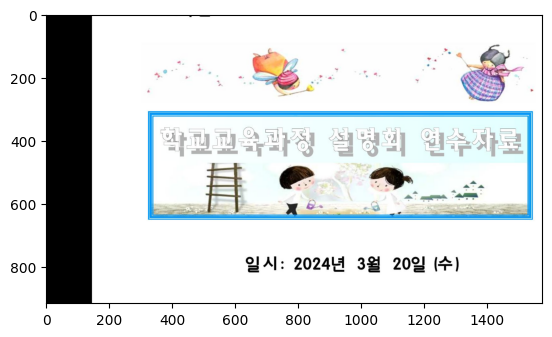

이 이미지는 한국어로 된 학교 행사 안내문처럼 보입니다. 상단에는 귀여운 만화 캐릭터들(꿀벌과 요정 같은 모습)이 그려져 있고, 중앙에는 한글로 된 제목이 있습니다. 그 아래에는 두 명의 어린이 캐릭터가 꽃을 심거나 가꾸는 듯한 모습이 그려져 있으며, 배경에는 사다리와 마을 풍경이 보입니다. 이미지 하단에는 "일시: 2024년 3월 20일 (수)"라고 적혀 있어 행사 날짜를 알려주고 있습니다. 전체적으로 봄과 새 학기를 연상시키는 밝고 따뜻한 분위기의 이미지입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이 이미지는 한국어로 된 학교 행사 안내문처럼 보입니다. 상단에는 귀여운 만화 캐릭터들(꿀벌과 요정 같은 모습)이 그려져 있고, 중앙에는 한글로 된 제목이 있습니다. 그 아래에는 두 명의 어린이 캐릭터가 꽃을 심거나 가꾸는 듯한 모습이 그려져 있으며, 배경에는 사다리와 마을 풍경이 보입니다. 이미지 하단에는 "일시: 2024년 3월 20일 (수)"라고 적혀 있어 행사 날짜를 알려주고 있습니다. 전체적으로 봄과 새 학기를 연상시키는 밝고 따뜻한 분위기의 이미지입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
0


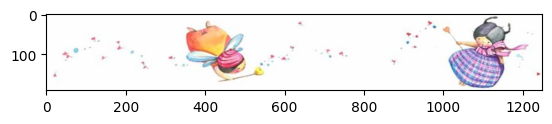

KeyboardInterrupt: 

In [195]:
image_summaries = []
for idx, img_base64 in enumerate(img_info):
    summary = summary_img(summarize_chain, img_base64)
    image_summaries.append(summary)
    print ("\n==")
    print (idx)
    
#image_summaries = summarize_chain.batch(img_info, config={"max_concurrency": 1})

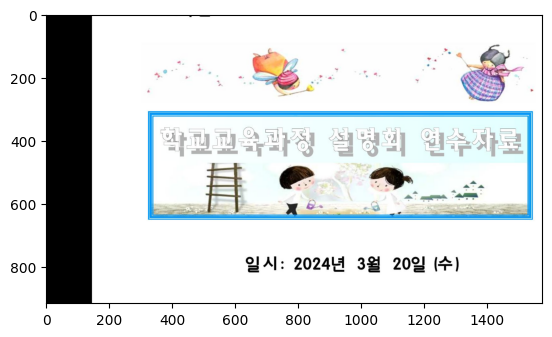

Summary: 이 이미지는 한국어로 된 학교 행사 안내문처럼 보입니다. 상단에는 귀여운 만화 캐릭터들(꿀벌과 요정 같은 모습)이 그려져 있고, 중앙에는 한글로 된 제목이 있습니다. 그 아래에는 두 명의 어린이 캐릭터가 꽃을 심거나 가꾸는 듯한 모습이 그려져 있으며, 배경에는 사다리와 마을 풍경이 보입니다. 이미지 하단에는 "일시: 2024년 3월 20일 (수)"라고 적혀 있어 행사 날짜를 알려주고 있습니다. 전체적으로 봄과 새 학기를 연상시키는 밝고 따뜻한 분위기의 이미지입니다.


In [196]:
verbose = True
if verbose:
    for img_base64, summary in zip(img_info, image_summaries):

        print ("============================")
        img = Image.open(BytesIO(base64.b64decode(img_base64)))
        plt.imshow(img)
        plt.show()

        print (f'Summary: {summary}')

`요약`된 내용을 Document의 `page_content`로, `OCR`결과는 metadata의 `origin_image`로 사용

In [197]:
images_preprocessed = []

for img_path, image_base64, summary in zip(images, img_info, image_summaries):
    
    metadata = {}
    metadata["img_path"] = img_path
    metadata["category"] = "Image"
    metadata["image_base64"] = image_base64
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

### For tables

In [198]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [199]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

In [200]:
if table_by_llama_parse and table_by_pymupdf:
    tables = tables + docs_table_llamaparse + docs_table_pymupdf
elif table_by_llama_parse:
    tables = tables + docs_table_llamaparse
elif table_by_pymupdf:
    tables = tables + docs_table_pymupdf

NameError: name 'table_by_pymupdf' is not defined

In [201]:
table_info = [(t.page_content, t.metadata["text_as_html"]) for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})
if table_as_image: table_info = [(t.page_content, t.metadata["text_as_html"], t.metadata["image_base64"]) if "image_base64" in t.metadata else (t.page_content, t.metadata["text_as_html"], None) for t in tables]

In [202]:
from src.utils.common_utils import print_html

In [203]:
verbose = True
index = 0
if verbose:
    for table, summary in zip(table_info, table_summaries):

        if table_as_image:
            page_contents, table_as_html, img_base64 = table
        else: page_contents, table_as_html = table

        print ("============================")
        print (index)
        print (f'table: {page_contents}')
        print ("----------------------------")
        print (f'summary: {summary}')
        print ("----------------------------")
        #print (f'html:')
        #print_html(table_as_html)
        print ("----------------------------")
        if table_as_image and img_base64 is not None:
            print ("image")
            img = Image.open(BytesIO(base64.b64decode(img_base64)))
            plt.imshow(img)
            plt.show()
        index += 1


`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [204]:
tables_preprocessed = []

for origin, summary in zip(tables, table_summaries):
    metadata = origin.metadata
    metadata["origin_table"] = origin.page_content
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)

## 4. Index 생성
Document로 부터 추출한 text, table, 그리고 image 정보를 Amazon OpenSearch에 저장합니다. (인덱싱)  

### Index 이름 결정

In [205]:
import boto3
from src.utils.ssm import parameter_store

In [206]:
pm = parameter_store("ap-northeast-2")

In [207]:
index_name = "complex-doc-index"

In [208]:
pm.put_params(
    key="opensearch_index_name",
    value=f'{index_name}',
    overwrite=True,
    enc=False
)

Parameter stored successfully.


### Index 스키마 정의

In [209]:
index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                    'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'row': {'type': 'long'},
                    'type': {'type': 'keyword'},
                    'timestamp': {'type': 'float'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}",
                'method': {
                    'name': 'hnsw',
                    'space_type': 'cosinesimil',  # 여기로 이동
                    'engine': 'nmslib',
                    'parameters': {
                        'ef_construction': 128,
                        'm': 16
                    }
                }
            }
        }
    }
}

## 5. LangChain OpenSearch VectorStore 생성 
### 선수 조건

#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.

In [210]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

In [211]:
opensearch_domain_endpoint = opensearch_domain_endpoint
print(opensearch_domain_endpoint)
from opensearchpy import AWSV4SignerAuth, OpenSearch, RequestsHttpConnection
# AWS 자격 증명 생성
region = "ap-northeast-2"
credentials = boto3.Session().get_credentials()

# AWSV4SignerAuth 사용
auth = AWSV4SignerAuth(credentials, region, 'aoss')


https://kviqznsn9qgriwrn6wze.ap-northeast-2.aoss.amazonaws.com


### OpenSearch Client 생성

In [246]:
from src.utils.opensearch import opensearch_utils

In [247]:
aws_region = "ap-northeast-2"

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint
)

### 오픈 서치 인덱스 생성 
- 오픈 서치에 해당 인덱스가 존재하면, 삭제 합니다. 

In [248]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)
print(index_exists)
if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )

opensearch_utils.create_index(os_client, index_name, index_body)
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

index_name=complex-doc-index, exists=True
True

Deleting index:
{'acknowledged': True}

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'complex-doc-index'}
Index is created
{'complex-doc-index': {'aliases': {},
                       'mappings': {'properties': {'metadata': {'properties': {'row': {'type': 'long'},
                                                                               'source': {'type': 'keyword'},
                                                                               'timestamp': {'type': 'float'},
                                                                               'type': {'type': 'keyword'}}},
                                                   'text': {'analyzer': 'my_analyzer',
                                                            'type': 'text'},
                                                   'vector_field': {'dimension': 1024,
                                                                    'meth

### 랭체인 인덱스 연결 오브젝트 생성

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [215]:
from langchain.vectorstores import OpenSearchVectorSearch

In [216]:
import boto3
from opensearchpy import AWSV4SignerAuth, OpenSearch, RequestsHttpConnection
from langchain_community.vectorstores.opensearch_vector_search import OpenSearchVectorSearch

# AWS 자격 증명 생성
region = "ap-northeast-2"
credentials = boto3.Session().get_credentials()

# AWSV4SignerAuth 사용
auth = AWSV4SignerAuth(credentials, region, 'aoss')


vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=auth, # AWSV4SignerAuth 사용
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

### Chunking Strategy: Parent documents
* Chunk Size and Chunk Overlap Size

In [217]:
from src.utils.chunk import parant_documents

In [218]:
parent_chunk_size = 4096
parent_chunk_overlap = 0

child_chunk_size = 1024
child_chunk_overlap = 256

opensearch_parent_key_name = "parent_id"
opensearch_family_tree_key_name = "family_tree"

* Parent Chunking
    - create_parent_chunk() 아래와 같은 작업을 합니다.
    - all_docs 에 있는 문서를 parent_chunk_size 만큼으로 청킹 합니다.
    - Parent Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: parent
        - parent_id : None

In [219]:
parent_chunk_docs = parant_documents.create_parent_chunk(
    docs=texts,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name,
    parent_chunk_size=parent_chunk_size,
    parent_chunk_overlap=parent_chunk_overlap
)
print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')

Number of parent_chunk_docs= 24


* Insert doc into OpenSearch 

In [263]:
import boto3
from opensearchpy import AWSV4SignerAuth, OpenSearch, RequestsHttpConnection
from langchain_community.vectorstores.opensearch_vector_search import OpenSearchVectorSearch

# AWS 자격 증명 생성
region = "ap-northeast-2"
credentials = boto3.Session().get_credentials()

# AWSV4SignerAuth 사용
auth = AWSV4SignerAuth(credentials, region, 'aoss')

# Vector DB 클라이언트 생성
vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    embedding_function=llm_emb,
    opensearch_url=opensearch_domain_endpoint,
    http_auth=auth,  # AWSV4SignerAuth 사용
    is_aoss=True,
    engine="faiss",
    space_type="l2",
    timeout=60,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection
)

In [264]:

%%time

parent_ids = vector_db.add_documents(
    documents = parent_chunk_docs, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 189 ms, sys: 477 μs, total: 190 ms
Wall time: 5.04 s


In [265]:
total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("total count docs: ", total_count_docs)

total count docs:  {'count': 0, '_shards': {'total': 0, 'successful': 0, 'skipped': 0, 'failed': 0}}


* 삽입된 Parent Chunk 의 첫번째를 확인 합니다. family_tree, parent_id 의 값을 확인 하세요.

In [266]:

print("First document ID:", parent_ids[0])

First document ID: 97d85b00-79d2-452c-9bd8-623f737db9ec


In [274]:
from opensearch import opensearch_utils

ModuleNotFoundError: No module named 'opensearch'

In [268]:

def show_opensearch_doc_info(response):
    if not response:
        print("No document found")
        return
        
    try:
        # OpenSearch 검색 결과 구조에 맞게 수정
        doc = response if "_id" in response else response["_source"]
        
        print("opensearch document id:", doc.get("_id", "N/A"))
        print("family_tree:", doc.get("_source", {}).get("metadata", {}).get("family_tree", "N/A"))
        print("parent document id:", doc.get("_source", {}).get("metadata", {}).get("parent_id", "N/A"))
        print("parent document text:\n", doc.get("_source", {}).get("text", "N/A"))
    except Exception as e:
        print(f"Error processing document: {str(e)}")

# 사용 예시
print(parent_ids[0], index_name)
response = opensearch_utils.get_document(os_client, doc_id=parent_ids[0], index_name=index_name)

show_opensearch_doc_info(response)

97d85b00-79d2-452c-9bd8-623f737db9ec complex-doc-index


RequestError: RequestError(400, '{"error":{"root_cause":[{"type":"null_pointer_exception","reason":"Cannot invoke \\"org.opensearch.cluster.ClusterState.blocks()\\" because \\"s')

* Child Chunking
    - 아래의 create_child_chunk() 는 다음과 같은 작업을 합니다.
    - parent_chunk_docs 각각에 대해서 Child Chunk 를 생성 합니다. 
    - Child Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: child
        - parent_id : parent 에 대한 OpenSearch document id

In [258]:
# child_chunk_docs = create_child_chunk(parent_chunk_docs[0:1], parent_ids)
child_chunk_docs = parant_documents.create_child_chunk(
    child_chunk_size=child_chunk_size,
    child_chunk_overlap=child_chunk_overlap,
    docs=parent_chunk_docs,
    parent_ids_value=parent_ids,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name
)

print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")

Number of child_chunk_docs= 79


In [259]:
parent_id = child_chunk_docs[0].metadata["parent_id"]
print("child's parent_id: ", parent_id)
print("\n###### Search parent in OpenSearch")
response = opensearch_utils.get_document(os_client, doc_id = parent_id, index_name = index_name)
show_opensearch_doc_info(response)    

child's parent_id:  718f09ce-47a0-4bc1-bb99-6738fa60267a

###### Search parent in OpenSearch


RequestError: RequestError(400, '{"error":{"root_cause":[{"type":"null_pointer_exception","reason":"Cannot invoke \\"org.opensearch.cluster.ClusterState.blocks()\\" because \\"s')

In [ ]:
child_chunk_docs[0]

### Manipulate table and image for parent documents
- set family_tree of table and image documents as "parent_table" and these kinds of types are included in searcable list (child, parent_table and parent_image) in parant document strategy.

In [ ]:
for table in tables_preprocessed:
    table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"

In [ ]:
for image in images_preprocessed:
    image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"

### Merge text, table and image

In [ ]:
from itertools import chain

In [ ]:
docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))

* Insert doc into OpenSearch

In [ ]:
%%time

child_ids = vector_db.add_documents(
    documents=docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size=1000000
)

print("length of child_ids: ", len(child_ids))

## 6. 검색 테스트

In [ ]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

In [ ]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=7, # 최종 Document 수 정의
    verbose=False,

)

### 하이브리드 검색

In [ ]:
%%time
query = "디지털 성범죄란?"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

In [ ]:
show_context_used(search_hybrid_result)